In [1]:
import pandas as pd

orders = pd.read_csv('../data/raw/olist_orders_dataset.csv')
order_items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
payments = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')
customers = pd.read_csv('../data/raw/olist_customers_dataset.csv')

In [6]:
order_revenue = payments.groupby('order_id')['payment_value'].sum().reset_index()

order_revenue.head()

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [9]:
orders_revenue = orders.merge(order_revenue, on='order_id', how='left')

orders_revenue = orders_revenue.merge(customers[['customer_id', 'customer_unique_id']],
                                      on='customer_id',
                                      how='left')

orders_revenue.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,38.71,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,72632f0f9dd73dfee390c9b22eb56dd6


In [10]:
orders_revenue['order_purchase_timestamp'] = pd.to_datetime(
    orders_revenue['order_purchase_timestamp']
)

customer_metrics = orders_revenue.groupby('customer_unique_id').agg(
    total_orders=('order_id', 'nunique'),
    total_revenue=('payment_value', 'sum'),
    last_purchase=('order_purchase_timestamp', 'max')
).reset_index()

customer_metrics.head()

,customer_unique_id,total_orders,total_revenue,last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14 19:45:42


In [11]:
reference_date = orders_revenue['order_purchase_timestamp'].max()

customer_metrics['recency_days'] = (
    reference_date - customer_metrics['last_purchase']
).dt.days

customer_metrics.head()

,customer_unique_id,total_orders,total_revenue,last_purchase,recency_days
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,2018-05-10 10:56:27,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07 11:11:27,163
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10 21:05:03,585
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12 20:29:41,369
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14 19:45:42,336


In [12]:
def segment_customer(row):
    if row['total_orders'] == 1:
        return 'One-time'
    elif row['total_orders'] > 1 and row['recency_days'] <= 90:
        return 'Active Repeat'
    elif row['total_orders'] > 1 and row['recency_days'] > 90:
        return 'Churn Risk'
    else:
        return 'Other'


customer_metrics['segment'] = customer_metrics.apply(segment_customer, axis=1)

customer_metrics['segment'].value_counts()

segment
One-time         93099
Churn Risk        2644
Active Repeat      353
Name: count, dtype: int64

In [13]:
segment_summary = customer_metrics.groupby('segment').agg(
    customers=('customer_unique_id', 'count'),
    total_revenue=('total_revenue', 'sum'),
    avg_revenue_per_customer=('total_revenue', 'mean')
).reset_index()

segment_summary

,segment,customers,total_revenue,avg_revenue_per_customer
0,Active Repeat,353,125211.87,354.707847
1,Churn Risk,2644,818810.84,309.686399
2,One-time,93099,15064849.41,161.815373


In [14]:
segment_summary['revenue_share_%'] = (
    segment_summary['total_revenue'] /
    segment_summary['total_revenue'].sum()
) * 100

segment_summary

,segment,customers,total_revenue,avg_revenue_per_customer,revenue_share_%
0,Active Repeat,353,125211.87,354.707847,0.782140
1,Churn Risk,2644,818810.84,309.686399,5.114732
2,One-time,93099,15064849.41,161.815373,94.103128


Business Insight!
94% total revenue comes from one-time customers.
Active repeat customers generate over 2x higher average revenue.
Increasing retention rate could sigificantly increase total revenue.

In [16]:
orders_revenue['order_month'] = (
    orders_revenue['order_purchase_timestamp']
    .dt.to_period('M')
)

In [17]:
cohort = orders_revenue.groupby('customer_unique_id')['order_month'] \
    .min() \
    .reset_index()

cohort.columns = ['customer_unique_id', 'cohort_month']

cohort.head()

,customer_unique_id,cohort_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [18]:
orders_cohort = orders_revenue.merge(
    cohort,
    on='customer_unique_id'
)

orders_cohort.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,customer_unique_id,order_month,cohort_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,38.71,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,af07308b275d755c9edb36a90c618231,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02


In [19]:
orders_cohort['cohort_index'] = (
    (orders_cohort['order_month'] - orders_cohort['cohort_month'])
    .apply(lambda x: x.n)
)

orders_cohort.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,customer_unique_id,order_month,cohort_month,cohort_index
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,38.71,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,af07308b275d755c9edb36a90c618231,2018-07,2018-07,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02,0


In [20]:
cohort_data = orders_cohort.groupby(
    ['cohort_month', 'cohort_index']
)['customer_unique_id'] \
    .nunique() \
    .reset_index()

cohort_data.head()

,cohort_month,cohort_index,customer_unique_id
0,2016-09,0,4
1,2016-10,0,321
2,2016-10,6,1
3,2016-10,9,1
4,2016-10,11,1


In [21]:
cohort_pivot = cohort_data.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='customer_unique_id'
)

cohort_pivot.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN


In [22]:
cohort_size = cohort_pivot[0]

retention = cohort_pivot.divide(cohort_size, axis=0)

retention.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN


In [24]:
retention_percent = retention * 100
retention_percent.round(2).head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,NaN,NaN,NaN,NaN,NaN,0.31,NaN,NaN,0.31,NaN,0.31,NaN,0.31,NaN,0.31,NaN,0.31,0.62,0.62
2016-12,100.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.39,0.26,0.13,0.39,0.13,0.52,0.13,0.13,NaN,0.39,0.13,0.79,0.39,0.13,0.13,0.26,0.39,0.13,NaN
2017-02,100.0,0.23,0.29,0.11,0.40,0.11,0.23,0.17,0.17,0.23,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.23,NaN,NaN


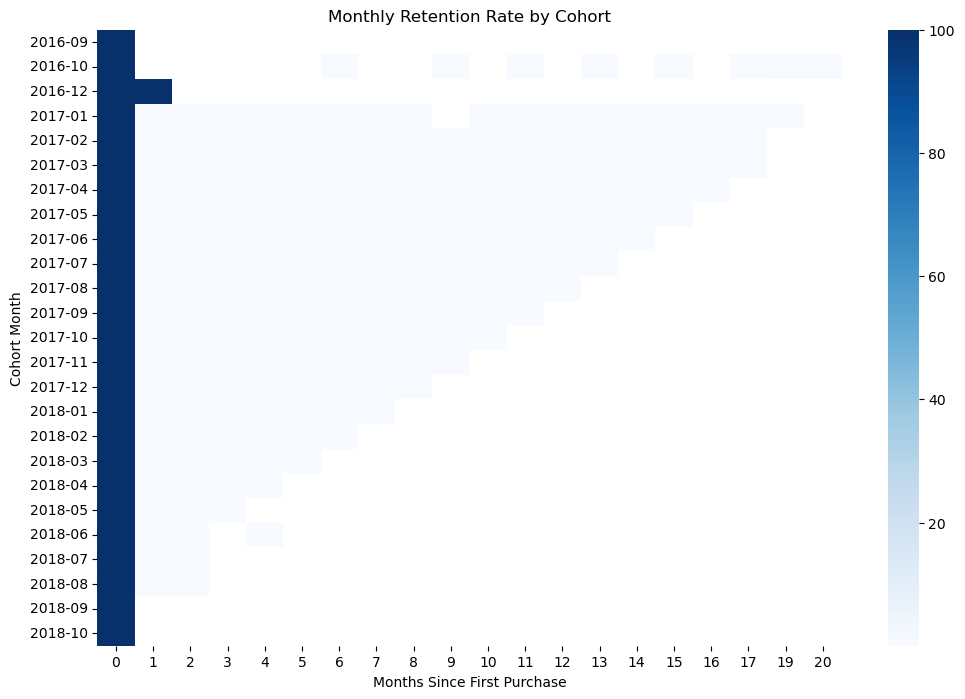

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

sns.heatmap(
    retention_percent,
    annot=False,
    fmt='.1f',
    cmap='Blues'
)

plt.title('Monthly Retention Rate by Cohort')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')

plt.show()

In [27]:
avg_revenue_per_customer = customer_metrics['total_revenue'].mean()
avg_orders_per_customer = customer_metrics['total_orders'].mean()
avg_revenue_per_order = (
    orders_revenue['payment_value'].sum() /
    orders_revenue['order_id'].nunique()
)

avg_revenue_per_customer, avg_orders_per_customer, avg_revenue_per_order

(np.float64(166.5924920912421),
 np.float64(1.0348089410589412),
 np.float64(160.98864774087147))

In [28]:
first_purchase = orders_revenue.groupby('customer_unique_id')[
    'order_purchase_timestamp'
].min()

customer_metrics = customer_metrics.merge(
    first_purchase,
    on='customer_unique_id',
    how='left'
)

customer_metrics.rename(
    columns={'order_purchase_timestamp': 'first_purchase'},
    inplace=True
)

customer_metrics['lifetime_days'] = (
    customer_metrics['last_purchase'] -
    customer_metrics['first_purchase']
).dt.days

customer_metrics['lifetime_months'] = (
    customer_metrics['lifetime_days'] / 30
)

customer_metrics[['lifetime_days', 'lifetime_months']].describe()

,lifetime_days,lifetime_months
count,96096.000000,96096.000000
mean,2.711507,0.090384
std,25.393343,0.846445
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,633.000000,21.100000


In [29]:
ltv_summary = {
    "avg_revenue_per_customer": avg_revenue_per_customer,
    "avg_orders_per_customer": avg_orders_per_customer,
    "avg_lifetime_months": customer_metrics['lifetime_months'].mean()
}

ltv_summary

{'avg_revenue_per_customer': np.float64(166.5924920912421),
 'avg_orders_per_customer': np.float64(1.0348089410589412),
 'avg_lifetime_months': np.float64(0.09038357475857475)}

In [30]:
import os

os.makedirs('../data/processed', exist_ok=True)

In [31]:
customer_metrics.to_csv('../data/processed/customer_metrics.csv', index=False)

segment_summary.to_csv('../data/processed/segment_summary.csv', index=False)

retention_percent.to_csv('../data/processed/retention_matrix.csv')

In [32]:
os.listdir('../data/processed')

['customer_metrics.csv', 'retention_matrix.csv', 'segment_summary.csv']